This notebook will go through the pipeline for normalizing an fMRI dataset into the MNI template space.

In [1]:
import os,shutil
import sklearn.metrics

try:
    datadir=os.environ['FMRIDATADIR']
    assert not datadir==''
except:
    datadir='/Users/poldrack/data_unsynced/myconnectome/sub00001'

print 'Using data from',datadir

%matplotlib inline

from nipype.interfaces import fsl
import nibabel
import numpy
import nilearn.plotting
import matplotlib.pyplot as plt


Using data from /Users/poldrack/data_unsynced/myconnectome/sub00001


In [2]:
subject='ses014'  
# note - we have to use the anatomy from a different session'
anat_subject='ses018'
bolddir=os.path.join(datadir,subject,
        'functional')
meanbold_unwarped_file=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold_mcf_brain_unwarped_mean.nii.gz')
bold_unwarped_file=os.path.join(bolddir,
    'sub00001_ses014_task002_run001_bold_mcf_unwarped.nii.gz')
anatomydir=os.path.join(datadir,anat_subject,
        'anatomy')
t1file=os.path.join(anatomydir,'sub00001_ses018_T1w_001.nii.gz')


Perform brain extraction using BET

In [3]:
t1brainfile=t1file.replace('.nii.gz','_brain.nii.gz')
btr = fsl.BET(frac=0.3)
btr.inputs.in_file = t1file
btr.inputs.out_file=t1brainfile
btr.inputs.mask=True
if not os.path.exists(btr.inputs.out_file):
    res = btr.run() 

Visualize brain mask overlaid on anatomy

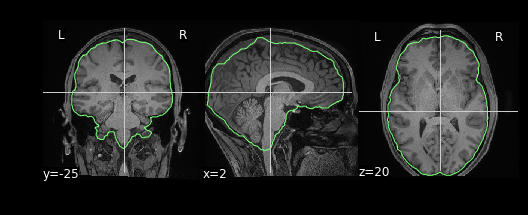

In [4]:
brainmask=nibabel.load(t1brainfile.replace('.nii.gz','_mask.nii.gz'))
maskdata=brainmask.get_data()
t1img=nibabel.load(t1file)

mask_display=nilearn.plotting.plot_epi(t1img,cmap='gray')
mask_display.add_contours(brainmask, levels=[.5]) 

Perform bias field correction on T1-weighted image using FSL's FAST.

In [5]:
bfcfile=os.path.join(anatomydir,'sub00001_ses018_T1w_001_brain_FAST_restore.nii.gz')

if not os.path.exists(bfcfile):
    fastr = fsl.FAST(verbose=True)
    fastr.inputs.in_files = t1brainfile
    fastr.inputs.output_biascorrected=True
    fastr.inputs.out_basename=t1brainfile.replace('.nii.gz','_FAST')
    try:
        out = fastr.run() 
    except FileNotFoundError:
        pass # FAST throws an error even if it finishes OK
else:
    print 'using existing bias-field corrected data'
# rename wmseg so that BFC will find it
wm_maskfile=os.path.join(anatomydir,'sub00001_ses018_T1w_001_brain_FAST_restore_wmseg.nii.gz')
if not os.path.exists(wm_maskfile):
    shutil.copy(os.path.join(anatomydir,'sub00001_ses018_T1w_001_brain_FAST_pve_2.nii.gz'),
            wm_maskfile)

using existing bias-field corrected data


Visualize white matter mask

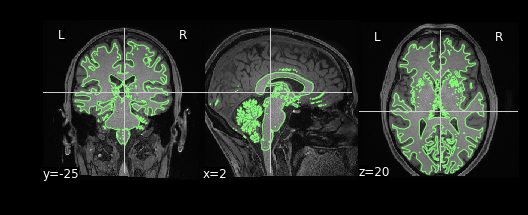

In [6]:
wm_mask=nibabel.load(wm_maskfile)

mask_display=nilearn.plotting.plot_epi(t1img,cmap='gray')
mask_display.add_contours(wm_mask, levels=[.5]) 

Register mean unwarped functional to anatomy using corratio

In [7]:
if not os.path.exists(meanbold_unwarped_file.replace('.nii.gz','_reg2t1.mat')):

    flt = fsl.FLIRT(cost_func='corratio',dof=7)
    flt.inputs.in_file = meanbold_unwarped_file
    flt.inputs.reference = bfcfile
    flt.inputs.out_file = meanbold_unwarped_file.replace('.nii.gz','_reg2t1.nii.gz')
    flt.inputs.out_matrix_file = meanbold_unwarped_file.replace('.nii.gz','_reg2t1.mat')
    flt.inputs.wm_seg=wm_maskfile
    flt.run()
else:
    print 'using existing corratio registration'

using existing corratio registration


Register mean unwarped functional to anatomy using BBR (using the matrix from the corratio registration as a starting point)

In [12]:
bbrmat=meanbold_unwarped_file.replace('.nii.gz','_bbreg2t1.mat')
if not os.path.exists(bbrmat):
    
    flt = fsl.FLIRT(cost_func='bbr',verbose=6,dof=7)
    flt.inputs.in_file = meanbold_unwarped_file
    flt.inputs.reference = bfcfile
    flt.inputs.schedule = os.path.join(os.getenv('FSLDIR'),
                                                'etc/flirtsch/bbr.sch')

    flt.inputs.out_file = meanbold_unwarped_file.replace('.nii.gz','_bbreg2t1.nii.gz')
    flt.inputs.in_matrix_file = meanbold_unwarped_file.replace('.nii.gz','_reg2t1.mat')
    flt.inputs.out_matrix_file = bbrmat
    flt.inputs.wm_seg=wm_maskfile
    # NOTE: This takes a VERY long time, so we probably want to 
    # save the matrix file in the data that are loaded to start with
    flt.run()
else:
    print 'using existing BBR file'



using existing BBR file


Which is better?

In [10]:
def calc_MI(x, y, bins=10):
    # compute mutual information between two variables
    c_xy = numpy.histogram2d(x, y, bins)[0]
    mi = sklearn.metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi

crfile=meanbold_unwarped_file.replace('.nii.gz','_reg2t1.nii.gz')
bbrfile=meanbold_unwarped_file.replace('.nii.gz','_bbreg2t1.nii.gz')
maskvox=numpy.where(maskdata)
bcfdata=nibabel.load(bfcfile).get_data()[maskvox]
crdata=nibabel.load(crfile).get_data()[maskvox]
bbrdata=nibabel.load(bbrfile).get_data()[maskvox]
if 1:
    print 'Mutual information with target:'
    mi_bbr=calc_MI(bcfdata,bbrdata)
    print 'BBR:',mi_bbr
    mi_cr=calc_MI(bcfdata,crdata)
    print 'corratio:',mi_cr

Mutual information with target:
BBR: 0.168297821129
corratio: 0.143466773313


Now let's register our functional data to the MNI template, and generate a composite transform.  Start out using FLIRT.

In [16]:
mnimat_flirt=bfcfile.replace('.nii.gz','_reg2mni.mat')
if not os.path.exists(mnimat_flirt):
    flt = fsl.FLIRT(cost_func='normcorr',dof=12)
    flt.inputs.in_file = bfcfile
    flt.inputs.reference = os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz')
    flt.inputs.out_file = bfcfile.replace('.nii.gz','_reg2mni.nii.gz')
    flt.inputs.out_matrix_file = mnimat_flirt
    flt.run()
else:
    print 'using existing FLIRT MNI registration'

In [19]:
if not os.path.exists(bfcfile.replace('.nii.gz','_nlreg2mni_field.mat')):

    flt = fsl.FNIRT()
    flt.inputs.in_file = bfcfile
    flt.inputs.affine_file=mnimat_flirt
    flt.inputs.ref_file = os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz')
    flt.inputs.warped_file = bfcfile.replace('.nii.gz','_nlreg2mni_warped.nii.gz')
    flt.inputs.field_file = bfcfile.replace('.nii.gz','_nlreg2mni_field')
    flt.run()
else:
    print 'using existing FLIRT MNI registration'

In [23]:
mnimaskdata=nibabel.load(os.path.join(os.getenv('FSLDIR'),
            'data/standard/MNI152_T1_2mm_brain_mask.nii.gz')).get_data()
mnimaskvox=numpy.where(mnimaskdata)
mnidata=nibabel.load(os.path.join(os.getenv('FSLDIR'),
            'data/standard/MNI152_T1_2mm_brain.nii.gz')).get_data()[mnimaskvox]

flirtimg=nibabel.load(bfcfile.replace('.nii.gz',
            '_reg2mni.nii.gz'))
flirtdata=flirtimg.get_data()[mnimaskvox]
fnirtimg=nibabel.load(bfcfile.replace('.nii.gz',
            '_nlreg2mni_warped.nii.gz'))
fnirtdata=fnirtimg.get_data()[mnimaskvox]
print 'Mutual information with target:'
mi_flirt=calc_MI(mnidata,flirtdata)
print 'FLIRT:',mi_flirt
mi_fnirt=calc_MI(mnidata,fnirtdata)
print 'FNIRT:',mi_fnirt

Mutual information with target:
FLIRT: 0.263166743147
FNIRT: 0.365428960543


Plot outlines onto template

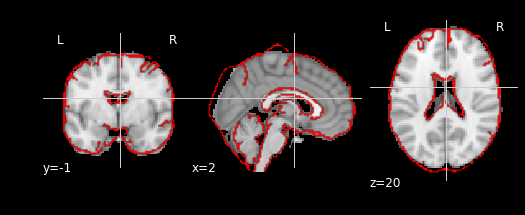

In [25]:
mniimg=nibabel.load(os.path.join(os.getenv('FSLDIR'),
                            'data/standard/MNI152_T1_2mm_brain.nii.gz'))

mask_display=nilearn.plotting.plot_epi(mniimg,cmap='gray')
mask_display.add_edges(flirtimg) 

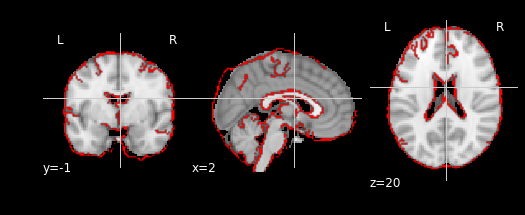

In [26]:
mask_display=nilearn.plotting.plot_epi(mniimg,cmap='gray')
mask_display.add_edges(fnirtimg) 

Apply FNIRT warp to EPI data

In [29]:
unwarped_reg2mni=bold_unwarped_file.replace('.nii.gz','_nlreg2mni.nii.gz')
if not os.path.exists(unwarped_reg2mni):
    aw = fsl.ApplyWarp()
    aw.inputs.in_file = bold_unwarped_file
    aw.inputs.ref_file = os.path.join(os.getenv('FSLDIR'),
                                'data/standard/MNI152_T1_2mm_brain.nii.gz')
    aw.inputs.field_file = bfcfile.replace('.nii.gz','_nlreg2mni_field.nii.gz')
    aw.inputs.postmat=mnimat_flirt
    aw.inputs.out_file=unwarped_reg2mni
    aw.run()
